In [1]:
import tensorflow as tf
import os
from utils import *
from tqdm import tqdm

In [2]:
max_N = 50
max_T = 120

def guided_attention(g=0.2):
    W = np.zeros((max_N, max_T), dtype=np.float32)
    for n_pos in range(W.shape[0]):
        for t_pos in range(W.shape[1]):
            W[n_pos, t_pos] = 1 - np.exp(-(t_pos / float(max_T) - n_pos / float(max_N)) ** 2 / (2 * g * g))
    return W

In [3]:
class Model:
    def __init__(
        self,
        num_layers,
        size_layers,
        learning_rate = 1e-3
    ):
        self.X = tf.placeholder(tf.int32, (None, None))
        self.training = tf.placeholder(tf.bool, None)
        lookup_table = tf.get_variable(
            'lookup_table',
            dtype = tf.float32,
            shape = [len(vocab), size_layers],
            initializer = tf.truncated_normal_initializer(
                mean = 0.0, stddev = 0.01
            ),
        )
        lookup_table = tf.concat(
            (tf.zeros(shape = [1, size_layers]), lookup_table[1:, :]), 0
        )
        self.X_seq_len = tf.count_nonzero(self.X, 1, dtype=tf.int32)
        self.gts = tf.convert_to_tensor(guided_attention())
        forward = tf.nn.embedding_lookup(lookup_table, self.X)
        self.Y = tf.placeholder(tf.float32, (None, None, n_mels * resampled))
        batch_size = tf.shape(self.Y)[0]
        self.decoder_inputs = tf.concat(
            (tf.ones_like(self.Y[:, :1, :]), self.Y[:, :-1, :]), 1
        )
        self.decoder_inputs = self.decoder_inputs[:, :, -n_mels:]
        
        self.Z = tf.placeholder(
            tf.float32, (None, None, fourier_window_size // 2 + 1)
        )
        
        seq_lens = tf.count_nonzero(
            tf.reduce_sum(self.decoder_inputs, -1), 1, dtype = tf.int32
        )
        
        def attention(encoder_out, seq_len, reuse=False):
            attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(num_units = size_layers, 
                                                                    memory = encoder_out,
                                                                    memory_sequence_length = seq_len)
            return tf.contrib.seq2seq.AttentionWrapper(
            cell = tf.nn.rnn_cell.MultiRNNCell([tf.contrib.rnn.GRUCell(size_layers) for _ in range(num_layers)]), 
                attention_mechanism = attention_mechanism,
                attention_layer_size = size_layers, alignment_history = True)
        
        encoder_cells = tf.nn.rnn_cell.MultiRNNCell([tf.contrib.rnn.GRUCell(size_layers) for _ in range(num_layers)])
        encoder_out, encoder_state = tf.nn.dynamic_rnn(cell = encoder_cells, 
                                                                 inputs = forward, 
                                                                 sequence_length = self.X_seq_len,
                                                                 dtype = tf.float32)
        
        encoder_state = tuple(encoder_state[-1] for _ in range(num_layers))
        decoder_cell = attention(encoder_out, seq_lens)
        encoder_state = decoder_cell.zero_state(batch_size, tf.float32).clone(cell_state=encoder_state)
        
        decoder_out, decoder_state = tf.nn.dynamic_rnn(cell = decoder_cell, 
                                                       inputs = self.decoder_inputs, 
                                                       sequence_length = seq_lens,
                                                       initial_state = encoder_state,
                                                       dtype = tf.float32)
        

        self.alignments = tf.transpose(
                decoder_state.alignment_history.stack(), [1, 2, 0]
            )
        
        
        self.Y_hat = tf.layers.dense(decoder_out, n_mels * resampled)
        out_decoder = tf.reshape(
                self.Y, [tf.shape(self.Y)[0], -1, n_mels]
        )
        for n in range(num_layers):
            (out_fw, out_bw), (state_fw, state_bw) = tf.nn.bidirectional_dynamic_rnn(
                cell_fw = tf.contrib.rnn.GRUCell(size_layers // 2),
                cell_bw = tf.contrib.rnn.GRUCell(size_layers // 2),
                inputs = out_decoder,
                dtype = tf.float32,
                scope = 'bidirectional_rnn_%d'%(n))
            out_decoder = tf.concat((out_fw, out_bw), 2)
        
        self.Z_hat = tf.layers.dense(out_decoder, 1 + fourier_window_size // 2)
        self.loss1 = tf.reduce_mean(tf.abs(self.Y_hat - self.Y))
        self.loss2 = tf.reduce_mean(tf.abs(self.Z_hat - self.Z))
        self.loss_bd1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.Y_hat, 
                                                                               labels=self.Y))
        self.A = tf.pad(self.alignments, [(0, 0), (0, max_N), (0, max_T)], 
                        mode="CONSTANT", constant_values=-1.)[:, :max_N, :max_T]
        self.attention_masks = tf.to_float(tf.not_equal(self.A, -1))
        self.loss_att = tf.reduce_sum(tf.abs(self.A * self.gts) * self.attention_masks)
        self.mask_sum = tf.reduce_sum(self.attention_masks)
        self.loss_att /= self.mask_sum
        self.loss_bd2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.Z_hat, 
                                                                          labels=self.Z))
        self.loss = self.loss1 + self.loss2 + self.loss_bd1 + self.loss_att + self.loss_bd2
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate = learning_rate
        ).minimize(self.loss)

In [7]:
paths, lengths, texts, raw_texts = [], [], [], []
text_files = [f for f in os.listdir('./mel') if f.endswith('.npy')]
for fpath in text_files:
    text = ' '.join([i for i in os.path.splitext(fpath)[0].split('-') if not i.isdigit()])
    paths.append(fpath.replace('.npy', ''))
    text = text_normalize(text)
    raw_texts.append(text)
    text = text + 'E'
    texts.append(np.array([char2idx[char] for char in text], np.int32))
    lengths.append(len(text))

In [8]:
paths[:2], lengths[:2], texts[:2]

(['sebut-perkataan-woman-anglish', 'tolong-sebut-pinachrome'],
 [30, 24],
 [array([22,  8,  5, 24, 23,  3, 19,  8, 21, 14,  4, 23,  4,  4, 17,  3, 26,
         18, 16,  4, 17,  3,  4, 17, 10, 15, 12, 22, 11,  2], dtype=int32),
  array([23, 18, 15, 18, 17, 10,  3, 22,  8,  5, 24, 23,  3, 19, 12, 17,  4,
          6, 11, 21, 18, 16,  8,  2], dtype=int32)])

In [9]:
def dynamic_batching(paths):
    files, max_y, max_z = [], 0, 0
    for n in range(len(paths)):
        files.append(get_cached(paths[n]))
        if files[-1][0].shape[0] > max_y:
            max_y = files[-1][0].shape[0]
        if files[-1][1].shape[0] > max_z:
            max_z = files[-1][1].shape[0]
    return files, max_y, max_z

In [10]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

size_layers = 128
learning_rate = 1e-2
num_layers = 2

model = Model(num_layers, size_layers, learning_rate)
sess.run(tf.global_variables_initializer())

minibatch loop: 100%|██████████| 46/46 [01:21<00:00,  1.70s/it, cost=1.5, loss1=0.0339, loss2=0.0318, loss_att=0.0111, loss_bd1=0.713, loss_bd2=0.707]  


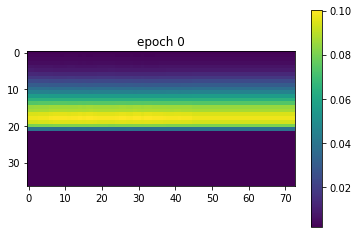

minibatch loop: 100%|██████████| 46/46 [01:20<00:00,  1.68s/it, cost=1.49, loss1=0.0316, loss2=0.0281, loss_att=0.00994, loss_bd1=0.712, loss_bd2=0.707]


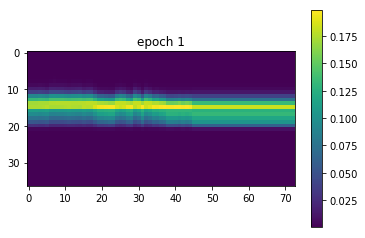

minibatch loop: 100%|██████████| 46/46 [01:21<00:00,  1.71s/it, cost=1.48, loss1=0.029, loss2=0.0253, loss_att=0.00628, loss_bd1=0.713, loss_bd2=0.707] 


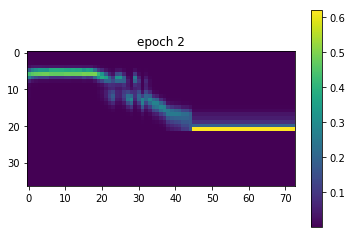

minibatch loop: 100%|██████████| 46/46 [01:22<00:00,  1.70s/it, cost=1.48, loss1=0.0283, loss2=0.0256, loss_att=0.00589, loss_bd1=0.713, loss_bd2=0.707]


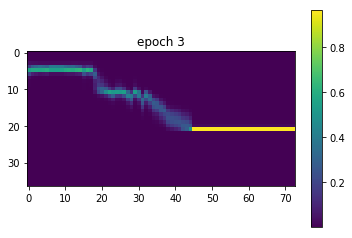

minibatch loop: 100%|██████████| 46/46 [01:20<00:00,  1.68s/it, cost=1.48, loss1=0.0272, loss2=0.0245, loss_att=0.00573, loss_bd1=0.713, loss_bd2=0.707] 


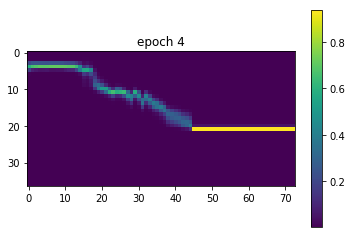

minibatch loop: 100%|██████████| 46/46 [01:21<00:00,  1.70s/it, cost=1.48, loss1=0.0261, loss2=0.0247, loss_att=0.00569, loss_bd1=0.713, loss_bd2=0.707] 


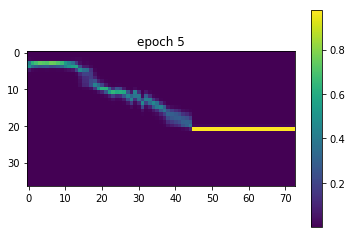

minibatch loop: 100%|██████████| 46/46 [01:20<00:00,  1.69s/it, cost=1.48, loss1=0.0263, loss2=0.023, loss_att=0.00566, loss_bd1=0.712, loss_bd2=0.708]  


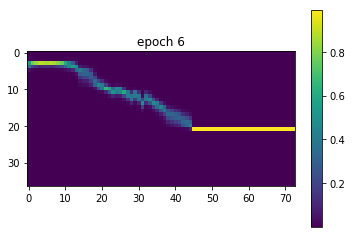

minibatch loop: 100%|██████████| 46/46 [01:21<00:00,  1.69s/it, cost=1.47, loss1=0.0255, loss2=0.0219, loss_att=0.00564, loss_bd1=0.712, loss_bd2=0.708] 


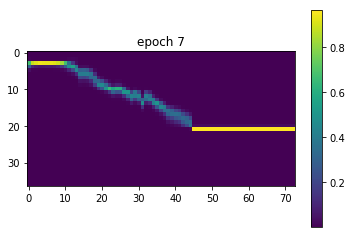

minibatch loop: 100%|██████████| 46/46 [01:20<00:00,  1.68s/it, cost=1.47, loss1=0.0261, loss2=0.0234, loss_att=0.00564, loss_bd1=0.712, loss_bd2=0.707] 


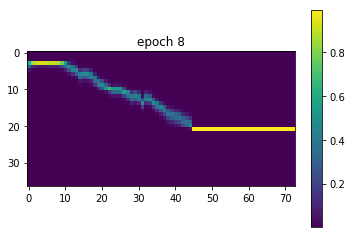

minibatch loop: 100%|██████████| 46/46 [01:20<00:00,  1.68s/it, cost=1.47, loss1=0.0247, loss2=0.0223, loss_att=0.00561, loss_bd1=0.712, loss_bd2=0.707] 


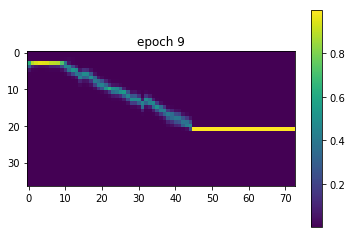

minibatch loop: 100%|██████████| 46/46 [01:20<00:00,  1.68s/it, cost=1.47, loss1=0.0241, loss2=0.0228, loss_att=0.00561, loss_bd1=0.713, loss_bd2=0.706] 


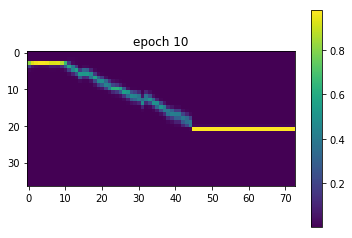

minibatch loop: 100%|██████████| 46/46 [01:20<00:00,  1.65s/it, cost=1.47, loss1=0.0238, loss2=0.0216, loss_att=0.00562, loss_bd1=0.713, loss_bd2=0.707] 


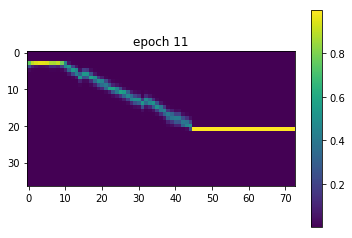

minibatch loop: 100%|██████████| 46/46 [01:19<00:00,  1.66s/it, cost=1.47, loss1=0.0237, loss2=0.0275, loss_att=0.00562, loss_bd1=0.712, loss_bd2=0.705] 


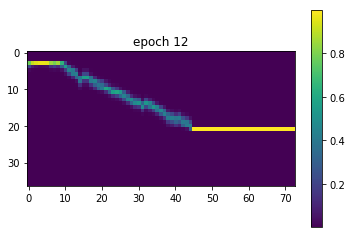

minibatch loop: 100%|██████████| 46/46 [01:19<00:00,  1.66s/it, cost=1.47, loss1=0.0231, loss2=0.0222, loss_att=0.00562, loss_bd1=0.713, loss_bd2=0.707] 


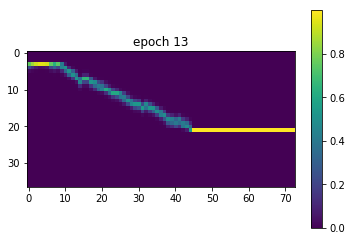

minibatch loop: 100%|██████████| 46/46 [01:19<00:00,  1.67s/it, cost=1.47, loss1=0.0226, loss2=0.0217, loss_att=0.0056, loss_bd1=0.713, loss_bd2=0.707]  


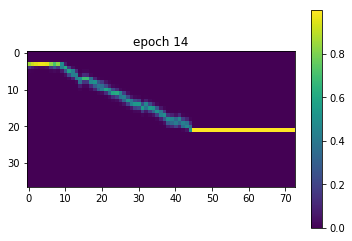

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.63s/it, cost=1.47, loss1=0.0228, loss2=0.0214, loss_att=0.00557, loss_bd1=0.713, loss_bd2=0.707] 


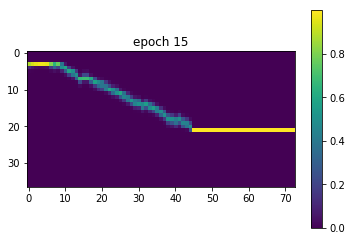

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.65s/it, cost=1.47, loss1=0.0225, loss2=0.0212, loss_att=0.00557, loss_bd1=0.713, loss_bd2=0.708] 


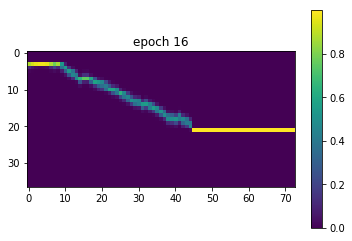

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.64s/it, cost=1.47, loss1=0.0226, loss2=0.0216, loss_att=0.00557, loss_bd1=0.713, loss_bd2=0.707] 


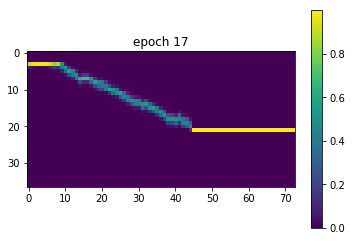

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.63s/it, cost=1.47, loss1=0.0224, loss2=0.0245, loss_att=0.00557, loss_bd1=0.713, loss_bd2=0.706] 


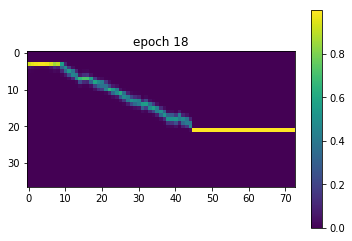

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.64s/it, cost=1.47, loss1=0.0222, loss2=0.0217, loss_att=0.00556, loss_bd1=0.713, loss_bd2=0.707] 


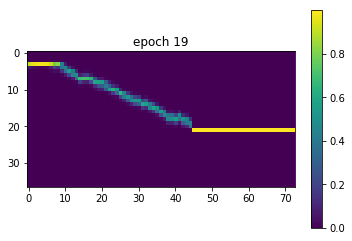

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.63s/it, cost=1.47, loss1=0.0219, loss2=0.0211, loss_att=0.00556, loss_bd1=0.713, loss_bd2=0.707] 


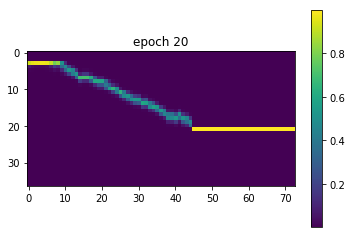

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.64s/it, cost=1.47, loss1=0.0218, loss2=0.0208, loss_att=0.00555, loss_bd1=0.713, loss_bd2=0.707] 


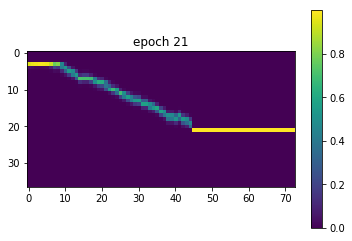

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.62s/it, cost=1.47, loss1=0.0218, loss2=0.0206, loss_att=0.00558, loss_bd1=0.713, loss_bd2=0.707] 


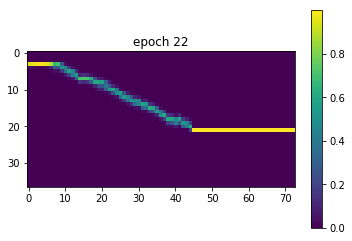

minibatch loop: 100%|██████████| 46/46 [01:17<00:00,  1.64s/it, cost=1.47, loss1=0.0218, loss2=0.0206, loss_att=0.00555, loss_bd1=0.713, loss_bd2=0.708] 


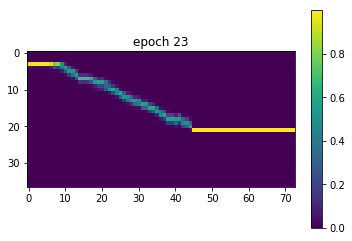

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.62s/it, cost=1.47, loss1=0.0215, loss2=0.0202, loss_att=0.00554, loss_bd1=0.713, loss_bd2=0.708] 


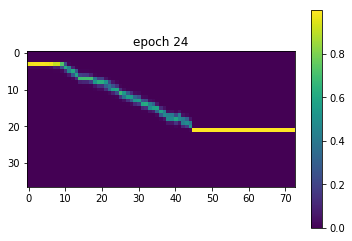

minibatch loop: 100%|██████████| 46/46 [01:17<00:00,  1.63s/it, cost=1.47, loss1=0.022, loss2=0.0207, loss_att=0.00555, loss_bd1=0.712, loss_bd2=0.707]  


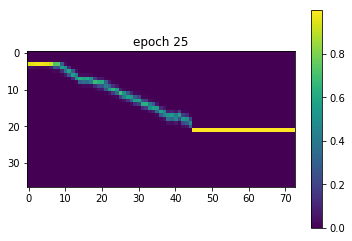

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.62s/it, cost=1.47, loss1=0.0219, loss2=0.0205, loss_att=0.00557, loss_bd1=0.712, loss_bd2=0.707] 


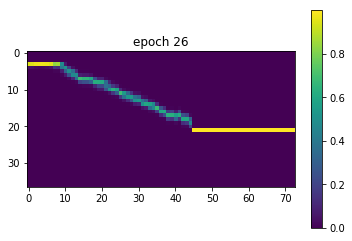

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.64s/it, cost=1.47, loss1=0.022, loss2=0.0201, loss_att=0.00557, loss_bd1=0.712, loss_bd2=0.707]  


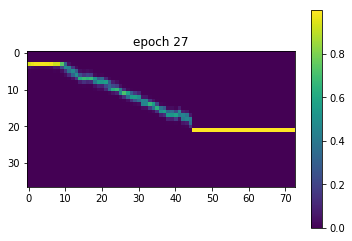

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.62s/it, cost=1.47, loss1=0.0213, loss2=0.0213, loss_att=0.00556, loss_bd1=0.713, loss_bd2=0.706] 


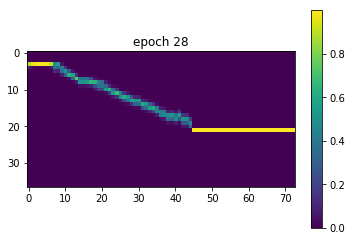

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.62s/it, cost=1.47, loss1=0.0213, loss2=0.0228, loss_att=0.00554, loss_bd1=0.713, loss_bd2=0.706] 


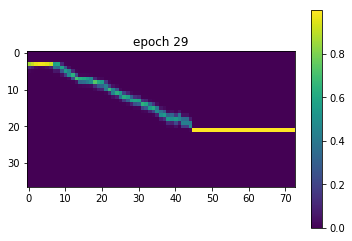

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.63s/it, cost=1.47, loss1=0.0213, loss2=0.0207, loss_att=0.00554, loss_bd1=0.713, loss_bd2=0.707] 


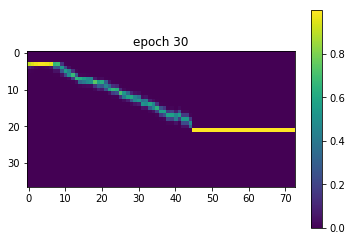

minibatch loop: 100%|██████████| 46/46 [01:17<00:00,  1.63s/it, cost=1.47, loss1=0.0212, loss2=0.0221, loss_att=0.00554, loss_bd1=0.713, loss_bd2=0.706] 


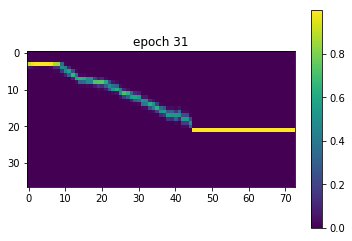

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.62s/it, cost=1.47, loss1=0.0212, loss2=0.026, loss_att=0.00555, loss_bd1=0.713, loss_bd2=0.707]  


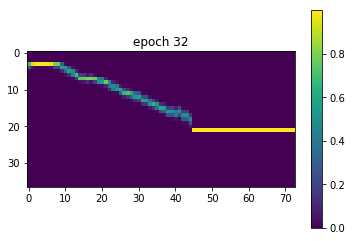

minibatch loop: 100%|██████████| 46/46 [01:17<00:00,  1.62s/it, cost=1.47, loss1=0.0209, loss2=0.0205, loss_att=0.00554, loss_bd1=0.713, loss_bd2=0.707] 


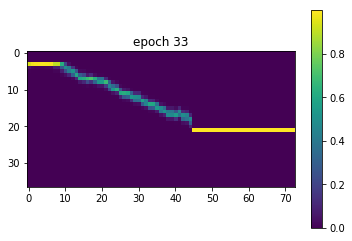

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.63s/it, cost=1.47, loss1=0.0207, loss2=0.0203, loss_att=0.00554, loss_bd1=0.714, loss_bd2=0.707] 


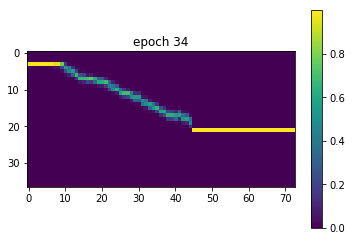

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.65s/it, cost=1.47, loss1=0.0214, loss2=0.0202, loss_att=0.00553, loss_bd1=0.712, loss_bd2=0.707] 


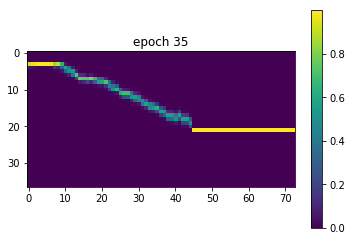

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.65s/it, cost=1.47, loss1=0.0213, loss2=0.0203, loss_att=0.00555, loss_bd1=0.713, loss_bd2=0.707] 


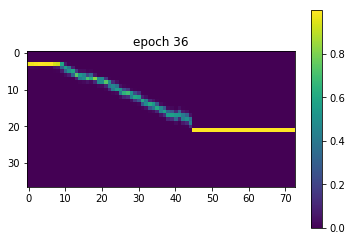

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.65s/it, cost=1.47, loss1=0.021, loss2=0.0203, loss_att=0.00557, loss_bd1=0.713, loss_bd2=0.707]  


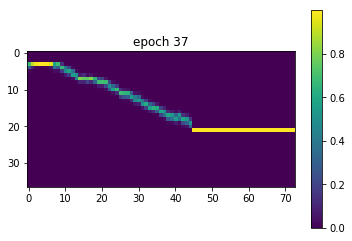

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.63s/it, cost=1.47, loss1=0.0212, loss2=0.0202, loss_att=0.00557, loss_bd1=0.713, loss_bd2=0.707] 


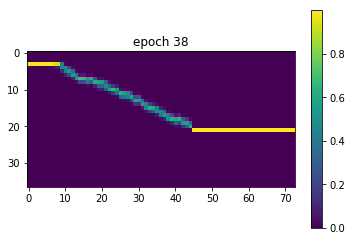

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.63s/it, cost=1.47, loss1=0.0207, loss2=0.0199, loss_att=0.00558, loss_bd1=0.713, loss_bd2=0.708] 


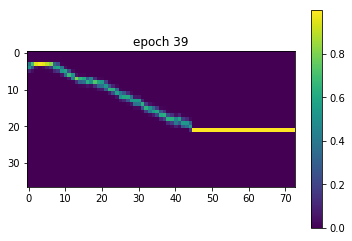

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.65s/it, cost=1.47, loss1=0.021, loss2=0.0205, loss_att=0.00554, loss_bd1=0.713, loss_bd2=0.707]  


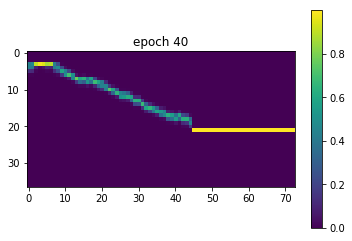

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.64s/it, cost=1.47, loss1=0.0209, loss2=0.0207, loss_att=0.00554, loss_bd1=0.713, loss_bd2=0.707] 


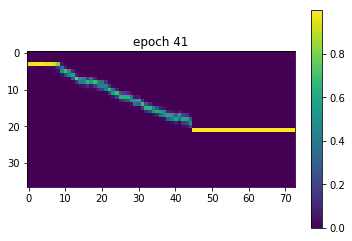

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.63s/it, cost=1.47, loss1=0.0212, loss2=0.0198, loss_att=0.00553, loss_bd1=0.712, loss_bd2=0.708]


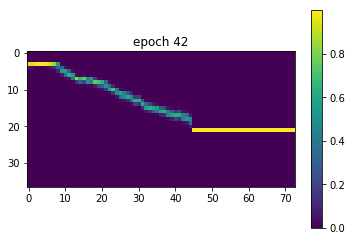

minibatch loop: 100%|██████████| 46/46 [01:19<00:00,  1.65s/it, cost=1.47, loss1=0.0212, loss2=0.0196, loss_att=0.00554, loss_bd1=0.712, loss_bd2=0.707] 


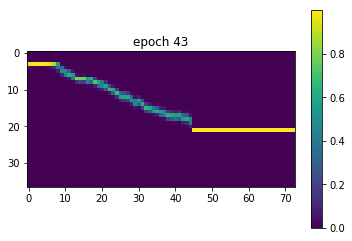

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.65s/it, cost=1.47, loss1=0.021, loss2=0.0208, loss_att=0.00554, loss_bd1=0.712, loss_bd2=0.707]  


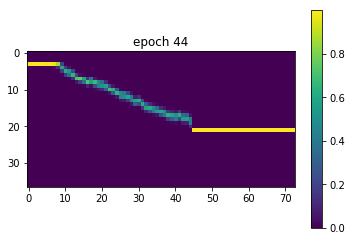

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.66s/it, cost=1.47, loss1=0.021, loss2=0.0203, loss_att=0.00554, loss_bd1=0.712, loss_bd2=0.707]  


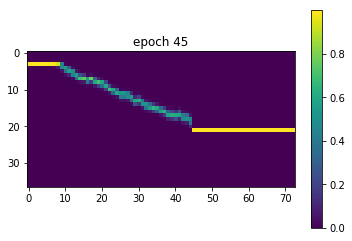

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.65s/it, cost=1.47, loss1=0.0211, loss2=0.0198, loss_att=0.00553, loss_bd1=0.712, loss_bd2=0.707]


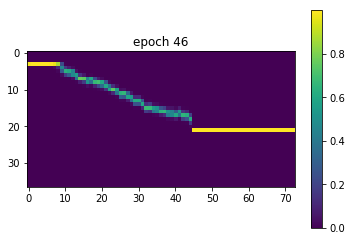

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.64s/it, cost=1.47, loss1=0.021, loss2=0.0209, loss_att=0.00554, loss_bd1=0.712, loss_bd2=0.706] 


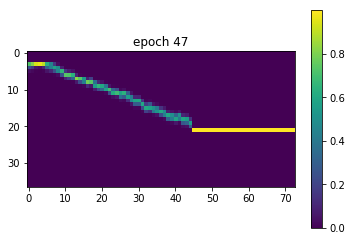

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.63s/it, cost=1.47, loss1=0.0207, loss2=0.02, loss_att=0.00553, loss_bd1=0.713, loss_bd2=0.707]  


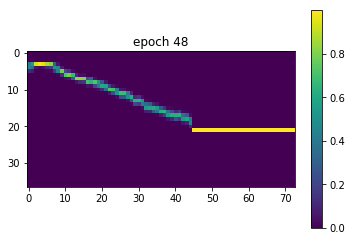

minibatch loop: 100%|██████████| 46/46 [01:18<00:00,  1.65s/it, cost=1.47, loss1=0.0217, loss2=0.0209, loss_att=0.00554, loss_bd1=0.712, loss_bd2=0.707]


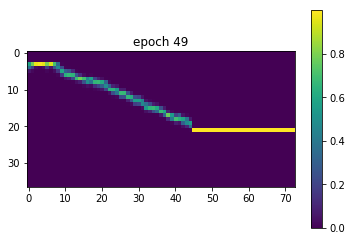

In [11]:
EPOCH = 50
for i in range(EPOCH):
    pbar = tqdm(range(0, len(paths), batch_size), desc = 'minibatch loop')
    for k in pbar:
        index = min(k + batch_size, len(paths))
        files, max_y, max_z = dynamic_batching(paths[k:index])
        max_x = max(lengths[k:index])
        batch_x = np.zeros((batch_size, max_x))
        batch_y = np.zeros((batch_size, max_y, n_mels * resampled))
        batch_z = np.zeros((batch_size, max_z, fourier_window_size // 2 + 1))
        for n in range(len(files)):
            batch_x[n, :] = np.pad(
                texts[k + n],
                ((0, max_x - texts[k + n].shape[0])),
                mode = 'constant',
            )
            batch_y[n, :, :] = np.pad(
                files[n][0],
                ((0, max_y - files[n][0].shape[0]), (0, 0)),
                mode = 'constant',
            )
            batch_z[n, :, :] = np.pad(
                files[n][1],
                ((0, max_z - files[n][1].shape[0]), (0, 0)),
                mode = 'constant',
            )
        _, cost, loss1, loss2, loss_bd1, loss_att, loss_bd2 = sess.run(
            [model.optimizer, model.loss, 
            model.loss1, model.loss2, model.loss_bd1,
            model.loss_att, model.loss_bd2],
            feed_dict = {model.X: batch_x, model.Y: batch_y, model.Z: batch_z},
        )
        pbar.set_postfix(cost = cost, loss1 = loss1, loss2 = loss2, loss_bd1 = loss_bd1,
                        loss_att = loss_att, loss_bd2 = loss_bd2)
        
    align = sess.run(
        model.alignments, feed_dict = {model.X: batch_x, model.Y: batch_y}
    )
    plot_alignment(align[0, :, :], i)

In [12]:
y_hat = np.ones((1, batch_y.shape[1], n_mels * resampled), np.float32)
for j in tqdm(range(batch_y.shape[1])):
    _y_hat = sess.run(model.Y_hat, {model.X: [texts[0]], model.Y: y_hat})
    y_hat[:, j, :] = _y_hat[:, j, :]

100%|██████████| 73/73 [00:08<00:00,  8.66it/s]


In [13]:
mags = sess.run(model.Z_hat, {model.Y: y_hat})

In [14]:
audio = spectrogram2wav(mags[0])

In [15]:
import IPython.display as ipd
ipd.Audio(audio, rate = sample_rate)

In [16]:
from scipy.io.wavfile import write
print('saving: %s'%(raw_texts[0]))
write(os.path.join('test-seq2seq-bahdanau.wav'), sample_rate, audio)

saving: sebut perkataan woman anglish


In [17]:
mags = sess.run(model.Z_hat, {model.Y: [batch_y[0]]})
audio = spectrogram2wav(mags[0])
ipd.Audio(audio, rate = sample_rate)

In [18]:
real_audio = spectrogram2wav(batch_z[0])
ipd.Audio(real_audio, rate = sample_rate)